In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import patsy
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split

%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data exploration

In [2]:
df = pd.read_pickle('df_for_analysis.pkl')

In [3]:
df.head(3)

,title,score_c,rating_c,score_u,rating_u,director,runtime,studio,audience_rating,month
0,Resident Evil: The Final Chapter,35,0.44,51.0,0.59,Paul W.S. Anderson,106.0,Sony Pictures,R,Jan
1,Passengers,31,0.49,63.0,0.47,Morten Tyldum,116.0,Columbia Pictures,PG-13,Dec
2,Beauty And The Beast (La Belle Et La Bête),32,0.46,53.0,0.66,Christophe Gans,112.0,NaN,PG-13,Jan


In [4]:
df[df.director == 'Brian Trenchard-Smith']

,title,score_c,rating_c,score_u,rating_u,director,runtime,studio,audience_rating,month
1237,Leprechaun 4: In Space,0,0.15,21.0,0.46,Brian Trenchard-Smith,90.0,NaN,R,Feb


In [5]:
df.describe()

,score_c,rating_c,score_u,rating_u,runtime
count,1484.000000,1484.000000,1483.000000,1484.000000,1483.000000
mean,55.001348,0.567372,56.159811,0.584717,102.884693
std,28.386814,0.152102,20.895911,0.141677,20.748629
min,0.000000,0.110000,4.000000,0.000000,1.000000
25%,31.000000,0.460000,40.000000,0.500000,90.000000
50%,57.000000,0.570000,57.000000,0.600000,99.000000
75%,80.000000,0.680000,72.500000,0.680000,112.000000
max,100.000000,0.970000,97.000000,0.950000,279.000000


In [6]:
df.corr()

,score_c,rating_c,score_u,rating_u,runtime
score_c,1.000000,0.939748,0.720985,0.749302,0.109175
rating_c,0.939748,1.000000,0.757236,0.756076,0.174577
score_u,0.720985,0.757236,1.000000,0.623714,0.266870
rating_u,0.749302,0.756076,0.623714,1.000000,0.079471
runtime,0.109175,0.174577,0.266870,0.079471,1.000000


In [7]:
# pairplot does not like NaN (actually it's numpy histogram that doesn't like it, but pairplot makes use of it).
for column in list(df):
    print(column, df[column].isnull().sum())

title 0
score_c 0
rating_c 0
score_u 1
rating_u 0
director 9
runtime 1
studio 716
audience_rating 0
month 0


There is a lot of null values in the 'studio' columns. Regression cannot deal with null values: depending on the method used, it either just drops rows with null values (statsmodels.formula.api) or gives an error (statsmodels.api, sklearn.LinearRegression). It would thus be better to either not to include the 'studio' variable in the analysis, or fill in the gaps with data from other sources, otherwise I loose more than half of the data.

In [8]:
len(df.dropna())

766

For now, I will simply drop the most problematic variables. Dropping 'studio' is not that straightforward, intuitively it seems like a relevant variable to predict popularity. Time permitting, I will scrape studio data from other sources.

In [9]:
df = df.drop(['studio'], 1)

In [10]:
len(df.dropna())

1473

I will mainly look at the ratings, since these are continuous variables, while scores are based on 'good' and 'bad' and thus represent a categorical variable despite being expressed in percentage.  

Create a new column that takes the average of critics and audience ratings?

* What is the average difference between the ratings?
* Can we simply average them?

In [11]:
difference = abs(df.rating_c - df.rating_u)
print(difference.mean())
print(difference.std())

0.0694743935309975
0.07805538616138238


The mean difference is of 7%, with a standard deviation of 8%. Too much variation in the differences, so not a very good idea to just average them.

In [12]:
df[df.director == 'Brian Trenchard-Smith']

,title,score_c,rating_c,score_u,rating_u,director,runtime,audience_rating,month
1237,Leprechaun 4: In Space,0,0.15,21.0,0.46,Brian Trenchard-Smith,90.0,R,Feb


In [13]:
df.head()

,title,score_c,rating_c,score_u,rating_u,director,runtime,audience_rating,month
0,Resident Evil: The Final Chapter,35,0.44,51.0,0.59,Paul W.S. Anderson,106.0,R,Jan
1,Passengers,31,0.49,63.0,0.47,Morten Tyldum,116.0,PG-13,Dec
2,Beauty And The Beast (La Belle Et La Bête),32,0.46,53.0,0.66,Christophe Gans,112.0,PG-13,Jan
3,Fantastic Beasts And Where To Find Them,73,0.68,79.0,0.70,David Yates (II),132.0,PG-13,Nov
4,Absolutely Anything,18,0.37,31.0,0.54,Terry Jones,85.0,NR,May


## Distribution of dependent variable

The dependent variables should have a normal distribution. Plot histograms to check whether transformtions are necessary:

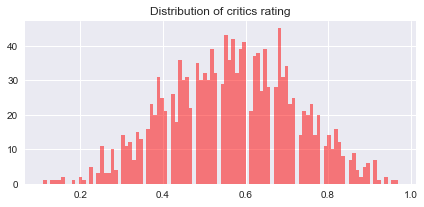

In [14]:
df.rating_c.hist(bins=100, color='r', alpha = 0.5, figsize=(7,3))
plt.title('Distribution of critics rating')
plt.savefig('dist_crating.pdf')

The distribution of rating_c seems normal, but there are some gaps.

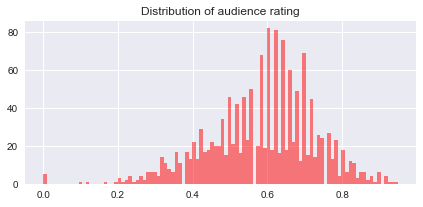

In [15]:
df.rating_u.hist(bins=100, color='r', alpha = 0.5, figsize=(7,3))
plt.title('Distribution of audience rating')
plt.savefig('dist.arating.pdf')

The distribution of rating_u is also pretty normal overall, but there seems to be some sort of frequency alternation.

I will not apply any type of transformation on the dependent variables.
Let's look at pairplots:

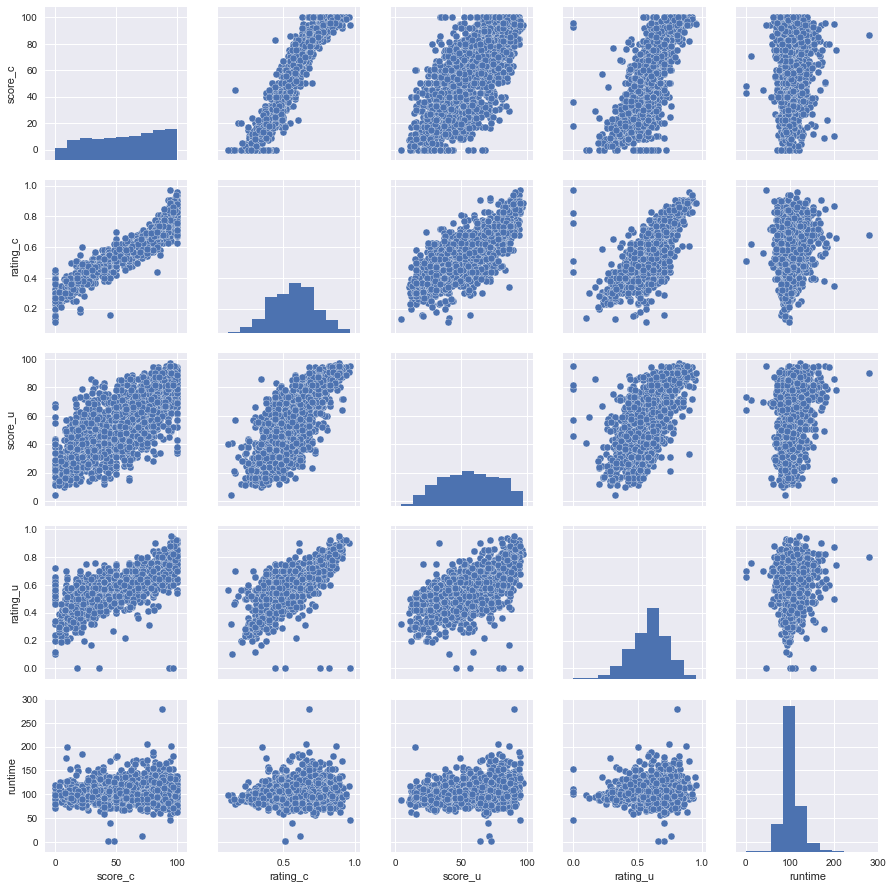

In [16]:
sns.pairplot(df.dropna())

In [17]:
df.corr()

,score_c,rating_c,score_u,rating_u,runtime
score_c,1.000000,0.939748,0.720985,0.749302,0.109175
rating_c,0.939748,1.000000,0.757236,0.756076,0.174577
score_u,0.720985,0.757236,1.000000,0.623714,0.266870
rating_u,0.749302,0.756076,0.623714,1.000000,0.079471
runtime,0.109175,0.174577,0.266870,0.079471,1.000000


Drop all rows containing NaN or we will run into trouble once we start making the model:

In [18]:
print(len(df))
df_no_na = df.dropna()
print(len(df_no_na))

1484
1473


In [19]:
df[df.director == 'Brian Trenchard-Smith']

,title,score_c,rating_c,score_u,rating_u,director,runtime,audience_rating,month
1237,Leprechaun 4: In Space,0,0.15,21.0,0.46,Brian Trenchard-Smith,90.0,R,Feb


In [20]:
df_no_na.head()

,title,score_c,rating_c,score_u,rating_u,director,runtime,audience_rating,month
0,Resident Evil: The Final Chapter,35,0.44,51.0,0.59,Paul W.S. Anderson,106.0,R,Jan
1,Passengers,31,0.49,63.0,0.47,Morten Tyldum,116.0,PG-13,Dec
2,Beauty And The Beast (La Belle Et La Bête),32,0.46,53.0,0.66,Christophe Gans,112.0,PG-13,Jan
3,Fantastic Beasts And Where To Find Them,73,0.68,79.0,0.70,David Yates (II),132.0,PG-13,Nov
4,Absolutely Anything,18,0.37,31.0,0.54,Terry Jones,85.0,NR,May


In [21]:
df_no_na.to_pickle('no_cat.pkl')

# Predicting rating: critics

## 1. Based on runtime

Let's make model to see whether rating_c can be predicted from runtime alone.

In [22]:
y = df_no_na.rating_c
X = df_no_na.runtime

# I will use a fixed random_state, in order to be able to compare the statsmodels with the sklearn output.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [23]:
def run_model_sm(X_train, y_train):
    lsm = smf.ols('y_train ~ X_train', data = X_train)
    lr = lsm.fit()
    return lr

In [24]:
lr_c_r = run_model_sm(X_train, y_train)
lr_c_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     24.29
Date:                Fri, 14 Jul 2017   Prob (F-statistic):           9.58e-07
Time:                        12:35:57   Log-Likelihood:                 514.86
No. Observations:                1104   AIC:                            -1026.
Df Residuals:                    1102   BIC:                            -1016.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4558      0.024     19.365      0.000       0.410       0.502
X_train        0.0011      0.000      4.928      0.000       0.001       0.002
==============================================================================
Omnibus:                       12.492   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                8.071
Skew:                           0.006   Prob(JB):                       0.0177
Kurtosis:                       2.581   Cond. No.                         540.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That looks pretty bad...  Let's plot some data.

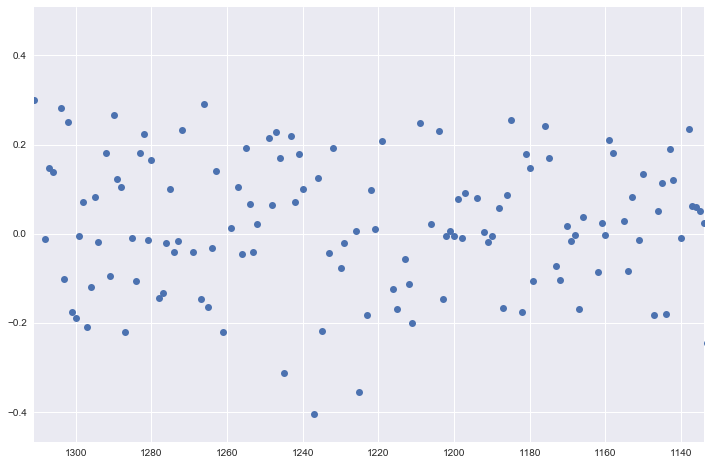

In [25]:
lr_c_r.resid.plot(style='o', figsize=(12,8))

The residuals have a random distribution, so we do not have to worry about transforming the dependent variable (as we already saw above).  
Let's see how the model does at predicting:

In [26]:
# With sklearn:
def run_model_sk(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr

In [27]:
# sklearn doesn't like series.
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

lr_sk = run_model_sk(X_train, y_train)
print('Training score: ', lr_sk.score(X_train, y_train))
print('Testing score: ', lr_sk.score(X_test, y_test))

Training score:  0.0215624322376
Testing score:  0.0530480708449


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


Plot of what we really have vs. what we predicted:

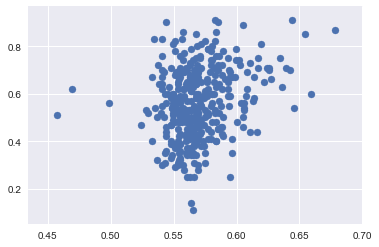

In [28]:
plt.scatter(lr_sk.predict(X_test.reshape(-1, 1)), y_test)
#plt.plot(y_test, lr_sk.predict(X_test.reshape(-1, 1)), color='green',
         #linewidth=2)
#plt.title('Regression for critics rating predicted by runtime')

Runtime is definitely not a good predictor for rating. I will include some categorical variables to see whether it gets any better.

## 2. Including categorical variables

We still didn't include the categorical variables. Let's Patsy them so they can also be included in the model.

* director
* audience_rating
* month

### Director

In [29]:
print(df_no_na.director.value_counts())

Tim Burton              10
Steven Spielberg        10
Peter Jackson           10
Robert Stevenson         8
Terry Gilliam            8
John Carpenter           7
Sam Raimi                7
Joe Dante                7
Robert Zemeckis          7
M. Night Shyamalan       7
David Cronenberg         7
Paul W.S. Anderson       7
Roland Emmerich          6
Ridley Scott             6
Bryan Singer             6
Michael Bay              6
James Cameron            6
Guillermo del Toro       5
Joe Johnston             5
Alex Proyas              5
Zack Snyder              5
Jack Arnold              5
Ivan Reitman             5
George Lucas             5
Don Coscarelli           5
David Yates (II)         5
Peter Hyams              5
David Twohy              5
Francis Lawrence         5
Russell Mulcahy          5
                        ..
Chris Roberts            1
Gunther v. Fritsch       1
Lynn Hershman-Leeson     1
Jeff Renfroe             1
Ben Wheatley             1
Dean Parisot             1
M

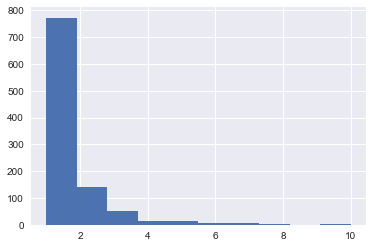

In [30]:
df_no_na.director.value_counts().hist(bins=10)

In [31]:
director = patsy.dmatrix('director',data=df_no_na,return_type='dataframe')
director.head(2)

,Intercept,director[T.Abel Ferrara],director[T.Adam Randall (II) ],director[T.Adam Shankman],director[T.Ajmal Zaheer Ahmad],director[T.Akira Kurosawa],director[T.Akiva Goldsman],director[T.Akiva Schaffer],director[T.Alain Resnais],director[T.Alan Johnson],...,director[T.Woody Allen],director[T.Wuershan],director[T.Wych Kaosayananda],director[T.Yakov Protazanov],director[T.Yorgos Lanthimos],director[T.Yoshitaka Amano],director[T.Yvan Attal],director[T.Zach Helm],director[T.Zack Snyder],director[T.Zhang Zhiliang]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
with_d = df_no_na.join(director).drop('Intercept', axis=1)

Let's see how the model does if we use both runtime and director as independent variables:

In [33]:
y = with_d.rating_c
X = with_d.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [34]:
lr_c_rd = run_model_sm(X_train, y_train)
lr_c_rd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     2.182
Date:                Fri, 14 Jul 2017   Prob (F-statistic):           7.07e-14
Time:                        12:35:59   Log-Likelihood:                 1613.2
No. Observations:                1104   AIC:                            -1574.
Df Residuals:                     278   BIC:                             2561.
Df Model:                         825                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6481      0.119      5.447      0.000       0.414       0.882
X_train[0]        0.0008      0.000      2.263      0.024       0.000       0.002
X_train[1]       -0.0915      0.158     -0.577      0.564      -0.403       0.220
X_train[2]       -0.1648      0.158     -1.041      0.299      -0.476       0.147
X_train[3]       -0.2882      0.158     -1.821      0.070      -0.600       0.023
X_train[4]       -0.4299      0.158     -2.717      0.007      -0.741      -0.118
X_train[5]       -0.1284      0.158     -0.812      0.418      -0.440       0.183
X_train[6]       -0.3893      0.158     -2.460      0.014      -0.701      -0.078
X_train[7]    -8.703e-16   1.78e-15     -0.489      0.625   -4.38e-15    2.64e-15
X_train[8]        0.1135      0.158      0.717      0.474      -0.198       0.425
X_train[9]    -1.022e-14   2.33e-15     -4.386      0.000   -1.48e-14   -5.63e-15
X_train[10]      -0.2841      0.158     -1.796      0.074      -0.596       0.027
X_train[11]      -0.3498      0.158     -2.208      0.028      -0.662      -0.038
X_train[12]      -0.1225      0.158     -0.775      0.439      -0.434       0.189
X_train[13]       0.0283      0.158      0.179      0.858      -0.283       0.340
X_train[14]    1.817e-15   8.63e-16      2.107      0.036    1.19e-16    3.52e-15
X_train[15]      -0.5923      0.158     -3.740      0.000      -0.904      -0.281
X_train[16]      -0.3372      0.158     -2.128      0.034      -0.649      -0.025
X_train[17]      -0.0492      0.137     -0.359      0.720      -0.319       0.220
X_train[18]   -1.306e-15   2.38e-15     -0.549      0.584   -5.99e-15    3.38e-15
X_train[19]    -1.16e-15   1.71e-15     -0.680      0.497   -4.52e-15     2.2e-15
X_train[20]       0.0735      0.158      0.464      0.643      -0.238       0.385
X_train[21]       0.0708      0.158      0.448      0.655      -0.241       0.382
X_train[22]      -0.2126      0.137     -1.551      0.122      -0.482       0.057
X_train[23]   -1.227e-15   1.05e-15     -1.171      0.243   -3.29e-15    8.36e-16
X_train[24]      -0.4775      0.158     -3.019      0.003      -0.789      -0.166
X_train[25]       0.0135      0.158      0.085      0.932      -0.298       0.325
X_train[26]       0.1402      0.158      0.885      0.377      -0.172       0.452
X_train[27]      -0.0490      0.158     -0.310      0.757      -0.361       0.262
X_train[28]       0.0858      0.129      0.664      0.507      -0.168       0.340
X_train[29]      -0.2306      0.158     -1.456      0.147      -0.542       0.081
X_train[30]      -0.5547      0.159     -3.498      0.001      -0.867      -0.243
X_train[31]      -0.3493      0.158     -2.207      0.028      -0.661      -0.038
X_train[32]      -0.1131      0.158     -0.715      0.476      -0.425       0.199
X_train[33]      -0.1074      0.138     -0.781   

This is way better! Let's see if it is also good at predicting data.

In [35]:
lr_rd = run_model_sk(X_train, y_train)
print('Training score: ', lr_rd.score(X_train, y_train))
print('Testing score: ', lr_rd.score(X_test, y_test))

Training score:  0.866219800578
Testing score:  -1.36594443489e+21


That's pretty horrible... We clearly have overfitting. Let's take a look at the p-values. I will extract them from the statsmodel because sklearn linear regression does not have a method to extract pvalues...

In [36]:
p_values = dict(lr_c_rd.pvalues)
coeff = dict(lr_c_rd.params)
low_ps = [k for k, v in p_values.items() if v<=.05]
print('low ps', len(low_ps))
print('total number of independent variables', len(p_values))

low ps 195
total number of independent variables 1014


Only 195 variables are lower than 0.05. However, I do not know if it is a good idea to take away part of a categorical variable. I will see if 'runtime' can be dropped.

In [37]:
'runtime' in low_ps

False

'Runtime' has a high p-value, let's see what happens when we drop it:

In [38]:
X = with_d.drop(['title', 'rating_c','runtime', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [39]:
lr_d = run_model_sk(X_train, y_train)
print('Training score: ', lr_d.score(X_train, y_train))
print('Testing score: ', lr_d.score(X_test, y_test))

Training score:  0.783450150279
Testing score:  -7.16501188806e+28


That's even worse, let's keep runtime.

### Rating

Runtime and rating as independent variables.

In [40]:
print(df_no_na.audience_rating.value_counts())

PG-13    406
R        393
PG       330
NR       213
G        127
NC17       4
Name: audience_rating, dtype: int64


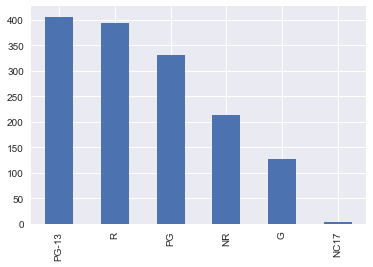

In [41]:
df_no_na.audience_rating.value_counts().plot(kind='bar')

In [42]:
rating = patsy.dmatrix('audience_rating',data=df_no_na,return_type='dataframe')
rating.head(2)

,Intercept,audience_rating[T.NC17],audience_rating[T.NR],audience_rating[T.PG],audience_rating[T.PG-13],audience_rating[T.R]
0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0


In [43]:
with_r = df_no_na.join(rating).drop('Intercept', axis = 1)

In [44]:
y = with_r.rating_c
X = with_r.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [45]:
lr_c_r = run_model_sm(X_train, y_train)
lr_c_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     22.20
Date:                Fri, 14 Jul 2017   Prob (F-statistic):           9.24e-25
Time:                        12:36:01   Log-Likelihood:                 566.08
No. Observations:                1104   AIC:                            -1118.
Df Residuals:                    1097   BIC:                            -1083.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4625      0.026     17.501      0.000       0.411       0.514
X_train[0]     0.0018      0.000      7.794      0.000       0.001       0.002
X_train[1]    -0.0778      0.075     -1.044      0.297      -0.224       0.068
X_train[2]     0.0126      0.020      0.643      0.520      -0.026       0.051
X_train[3]    -0.0838      0.019     -4.509      0.000      -0.120      -0.047
X_train[4]    -0.1199      0.019     -6.439      0.000      -0.156      -0.083
X_train[5]    -0.0907      0.018     -4.959      0.000      -0.127      -0.055
==============================================================================
Omnibus:                       14.896   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.206
Skew:                           0.004   Prob(JB):                       0.0100
Kurtosis:                       2.553   Cond. No.                     1.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
sk_rr = run_model_sk(X_train, y_train)
print('Training score: ', sk_rr.score(X_train, y_train))
print('Testing score: ', sk_rr.score(X_test, y_test))

Training score:  0.108265987294
Testing score:  0.105152906061


Predicting critic rating based on runtime and rating gives a bad model. No overfitting though. Without runtime:

In [47]:
X = with_r.drop(['title', 'rating_c','runtime', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sk_r = run_model_sk(X_train, y_train)
print('Training score: ', sk_r.score(X_train, y_train))
print('Testing score: ', sk_r.score(X_test, y_test))

Training score:  0.0588897133107
Testing score:  0.0111175024081


Nope...

### Month

In [48]:
df_no_na.month.value_counts()

Jun    168
Jan    151
Jul    139
Dec    136
Mar    130
Nov    118
Oct    113
Aug    108
May    106
Sep    100
Apr     84
Feb     81
NaT     39
Name: month, dtype: int64

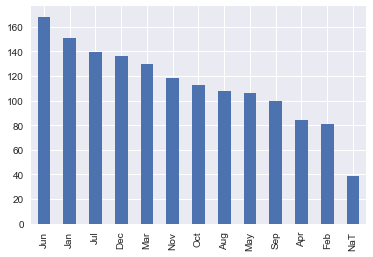

In [49]:
df_no_na.month.value_counts().plot(kind='bar')

In [50]:
month = patsy.dmatrix('month',data=df,return_type='dataframe')
month.head(2)

,Intercept,month[T.Aug],month[T.Dec],month[T.Feb],month[T.Jan],month[T.Jul],month[T.Jun],month[T.Mar],month[T.May],month[T.NaT],month[T.Nov],month[T.Oct],month[T.Sep]
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
with_m = df_no_na.join(month).drop('Intercept', axis = 1)

In [52]:
y = with_m.rating_c
X = with_m.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [53]:
lr_r_m = run_model_sm(X_train, y_train)
lr_r_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.663
Date:                Fri, 14 Jul 2017   Prob (F-statistic):            0.00110
Time:                        12:36:02   Log-Likelihood:                 520.09
No. Observations:                1104   AIC:                            -1012.
Df Residuals:                    1090   BIC:                            -942.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.4701      0.030     15.857      0.000       0.412       0.528
X_train[0]      0.0010      0.000      4.454      0.000       0.001       0.001
X_train[1]     -0.0368      0.026     -1.438      0.151      -0.087       0.013
X_train[2]      0.0097      0.025      0.396      0.692      -0.038       0.058
X_train[3]     -0.0324      0.027     -1.185      0.236      -0.086       0.021
X_train[4]     -0.0224      0.024     -0.940      0.347      -0.069       0.024
X_train[5]     -0.0137      0.024     -0.563      0.574      -0.061       0.034
X_train[6]     -0.0050      0.024     -0.213      0.831      -0.051       0.041
X_train[7]      0.0048      0.024      0.200      0.842      -0.042       0.052
X_train[8]      0.0101      0.026      0.393      0.694      -0.040       0.060
X_train[9]      0.0019      0.032      0.060      0.952      -0.061       0.065
X_train[10]    -0.0110      0.025     -0.444      0.657      -0.060       0.038
X_train[11]     0.0085      0.025      0.340      0.734      -0.041       0.058
X_train[12]     0.0045      0.027      0.169      0.866      -0.048       0.057
==============================================================================
Omnibus:                        9.479   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                6.552
Skew:                           0.016   Prob(JB):                       0.0378
Kurtosis:                       2.624   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
sk_r_m = run_model_sk(X_train, y_train)
print('Training score: ', sk_r_m.score(X_train, y_train))
print('Testing score: ', sk_r_m.score(X_test, y_test))

Training score:  0.030781646944
Testing score:  0.0424709986972


So far: model with both runtime and director has pretty good R squared, but suffers massively from overfitting. Other models have low R squares.
Let's include all categorical variables. Probably we will still have a not so good model, with an overfitting problem.

### All categorical variables

In [55]:
with_all_cat = df_no_na.join(month).drop('Intercept', axis = 1).join(director).drop('Intercept', axis = 1).join(rating).drop('Intercept', axis = 1)
with_all_cat.to_pickle('df_all_cat.pkl')

In [56]:
y = with_all_cat.rating_c
X = with_all_cat.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [57]:
# lsm_all_cat = smf.ols('y_train ~ X_train', data = data)
# add intercept because sklearn does this as well.
lr_all_cat = run_model_sm(X_train, y_train)
# lr_all_cat.summary()

In [58]:
lr_cat = run_model_sk(X_train, y_train)
print('Training score: ', lr_cat.score(X_train, y_train))
print('Testing score: ', lr_cat.score(X_test, y_test))

Training score:  0.873265974271
Testing score:  -3.10267596963e+21


I have a pretty good R-squared score for the training data, but a terrible one (negative...) for the testing data.

We have overfitting because of multicollinearity. Let's do a Ridge model (normalization is a precondition for regularization) to suppress the multicollinearity.

The model is worse on the train data, but at least there is no massive overfitting anymore. Let's find the best alpha:

In [59]:
for alpha in np.arange(0.1, 1, 0.1):
    print(alpha, Ridge(normalize=True, alpha=alpha).fit(X_train, y_train).score(X_test, y_test))

0.1 0.17909064047
0.2 0.193761811543
0.3 0.200930574845
0.4 0.204260785765
0.5 0.205158157176
0.6 0.20442937745
0.7 0.202597436899
0.8 0.200017826057
0.9 0.196938016588


We need to use a pretty big alpha (we heavily penalize big coefficients) to get a sensible model.

In [60]:
rid_c = Ridge(normalize=True, alpha = 0.5)
fit_c = rid_c.fit(X_train, y_train)
print(fit_c.score(X_train, y_train))
print(fit_c.score(X_test, y_test))

0.777505039645
0.205158157176


Which directors make the most popular movies?

In [61]:
# this cannot be correct... the first two suck big time, only the third one is good

zipped = zip(rid_c.coef_, X.columns)
sorted(zipped, key = lambda x: x[0], reverse=True)[:3]

[(0.26577792257393612, 'director[T.Buster Keaton]'),
 (0.24840633666669645, 'director[T.King Vidor]'),
 (0.23672901337181493, 'director[T.Hamilton Luske]')]

Which directors make the least popular movies?

In [62]:
# again, this is wrong, the forth one (why is it there anyway?) has super good ratings...

zipped = zip(rid_c.coef_, X.columns)
sorted(zipped, key = lambda x: x[0])[:3]

[(-0.28842021962385894, 'director[T.Albert Pyun]'),
 (-0.26920080494886894, 'director[T.Allan Arkush]'),
 (-0.26669713107523335, 'director[T.Brian Trenchard-Smith]')]

## Conclusion:

The best model so far to predict critics rating is with runtime, director, release month and rating as independent variables. The model is a Ridge model, with alpha = 0.5 

# Predicting ratings: audience

## 1. Based on Runtime

In [63]:
y = df_no_na.rating_u
X = df_no_na.runtime

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [64]:
sm_a_r = run_model_sm(X_train, y_train)
sm_a_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_train   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.695
Date:                Fri, 14 Jul 2017   Prob (F-statistic):             0.0548
Time:                        12:36:05   Log-Likelihood:                 605.64
No. Observations:                1104   AIC:                            -1207.
Df Residuals:                    1102   BIC:                            -1197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5479      0.022     25.276      0.000       0.505       0.590
X_train        0.0004      0.000      1.922      0.055   -8.23e-06       0.001
==============================================================================
Omnibus:                       37.317   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.913
Skew:                          -0.416   Prob(JB):                     7.92e-10
Kurtosis:                       3.467   Cond. No.                         540.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

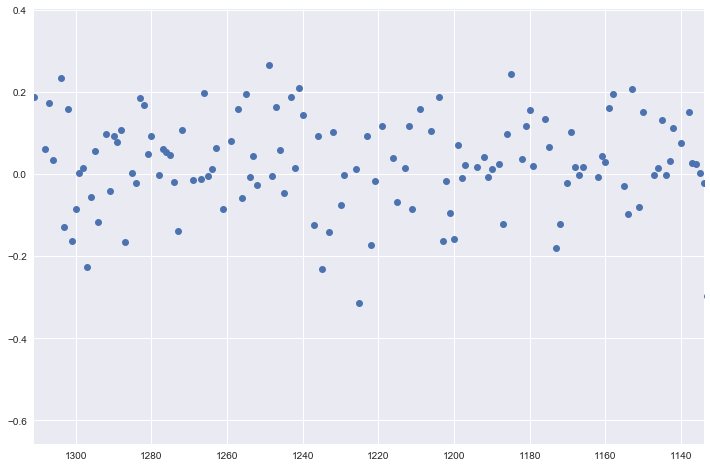

In [65]:
sm_a_r.resid.plot(style='o', figsize=(12,8))

In [66]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

sk_a_r = run_model_sk(X_train, y_train)
print('Training score: ', sk_a_r.score(X_train, y_train))
print('Testing score: ', sk_a_r.score(X_test, y_test))

Training score:  0.00334194754214
Testing score:  0.00136149190196


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


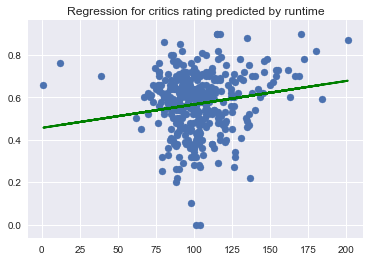

In [67]:
plt.scatter(X_test, y_test)
plt.plot(X_test, lr_sk.predict(X_test.reshape(-1, 1)), color='green',
         linewidth=2)
plt.title('Regression for critics rating predicted by runtime')

## 2. Including categorical data

### Director

In [68]:
y = with_d.rating_u
X = with_d.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sk_a_rd = run_model_sk(X_train, y_train)
print('Training score: ', sk_a_rd.score(X_train, y_train))
print('Testing score: ', sk_a_rd.score(X_test, y_test))

Training score:  0.847222104082
Testing score:  -5.85648360892e+20


### Rating

In [69]:
y = with_r.rating_u
X = with_r.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sk_a_rr = run_model_sk(X_train, y_train)
print('Training score: ', sk_a_rr.score(X_train, y_train))
print('Testing score: ', sk_a_rr.score(X_test, y_test))

Training score:  0.10890932473
Testing score:  0.0603832199111


### Month

In [70]:
y = with_m.rating_u
X = with_m.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sk_a_rm = run_model_sk(X_train, y_train)
print('Training score: ', sk_a_rm.score(X_train, y_train))
print('Testing score: ', sk_a_rm.score(X_test, y_test))

Training score:  0.0116932232734
Testing score:  -0.0088459313079


### All categorical variables

In [71]:
y = with_all_cat.rating_u
X = with_all_cat.drop(['title', 'rating_c', 'score_c', 'rating_u', 'score_u', 'director', 'audience_rating', 'month'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

sk_a_all = run_model_sk(X_train, y_train)
print('Training score: ', sk_a_all.score(X_train, y_train))
print('Testing score: ', sk_a_all.score(X_test, y_test))

Training score:  0.853730026015
Testing score:  -3.55311504186e+21


With all categorical variables it's the best.  
Let's normalize and regularize.

In [72]:
for alpha in np.arange(0.1, 1.1, 0.1):
    print(alpha, Ridge(normalize=True, alpha=alpha).fit(X_train, y_train).score(X_test, y_test))

0.1 0.0749034617849
0.2 0.0887983782803
0.3 0.0974448502903
0.4 0.102860988748
0.5 0.106091179758
0.6 0.107796311873
0.7 0.108421357111
0.8 0.108275248043
0.9 0.107576821921
1.0 0.106483448431


In [73]:
rid_a = Ridge(normalize=True, alpha=0.7)
fit_a = rid_a.fit(X_train, y_train)
print(fit_a.score(X_train, y_train))
print(fit_a.score(X_test, y_test))

0.715778311661
0.108421357111


In [74]:
zipped = zip(rid_a.coef_, X.columns)
sorted(zipped, key = lambda x: x[0], reverse=True)[:3]

[(0.19641580386891419, 'director[T.King Vidor]'),
 (0.19253973367994942, 'director[T.Jean Cocteau]'),
 (0.17959946520031048, 'director[T.Kenji Mizoguchi]')]

In [75]:
zipped = zip(rid_a.coef_, X.columns)
sorted(zipped, key = lambda x: x[0], reverse=False)[:3]

[(-0.37195597474811087, 'director[T.Raoul Walsh]'),
 (-0.35675622898215925, 'director[T.Buster Keaton]'),
 (-0.34891998270129598, 'director[T.John Alan Simon]')]

# Conclusion

For both critics and audience ratings, the model based on runtime + director + MPAA rating + release month is the easiest to fit, but is terrible at predicting ratings.  
Overall, __predicting critics ratings seems to be easier than predicting audience ratings__. This might be related to the fact that the audience is a more heterogeneous group than the critics group. Also, __director is the independent variable with the biggest impact__ (from R^2 around .2 to R^ around .8). However, director introduces massive multicollinearity, and even after normalization and Ridge regularization, the model continues to be bad at predicting ratings.  
__What is the precise impact of the director?__ Hard to tell based on this dataset: a lot of the directors in there made only one movie in the dataset. If a director got a bad score for his single movie, that doesn't tell us anything about the relation between directors and ratings. __Solution:__ look only at movies of productive directors. If one director made 10 movies, and her movies consistently got a good rating, it might be that the movie got a good rating because 